# Modular variables

In [121]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple example

In [122]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name="cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index=cells.index), label="x")

In [123]:
n_genes = 100
genes = la.Dim(pd.Series([str(i) for i in range(n_genes)]), name="gene")


def random_coefficient(n_genes):
    return (
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5)
    )


slope = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="slope"
)
intercept = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="intercept"
)
final = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="final"
)

slope_subset = la.Fixed(
    pd.Series(random_coefficient(10), index=genes.index[:10]), label="slope_subset"
)

In [124]:
y_linear = la.links.scalar.Linear(x=x, a=slope)
y = la.modular.Additive(
    linear=y_linear, definition=y_linear.value_definition, subsettable={genes}
)

[[parent.symbol]]_{\mathregular{linear}}


We can add extra terms:

In [125]:
y_sigmoid = la.links.scalar.Sigmoid(x=x, a=final)
y.sigmoid = y_sigmoid

y_exponential = la.links.scalar.Exp(x=x, a=final)
y.exponential = y_exponential

[[parent.symbol]]_{\mathregular{sigmoid}}
[[parent.symbol]]_{\mathregular{exponential}}


The terms can have a subset of the modular variable's dimensions:

In [126]:
y.simply_x = x
y.simply_slope = slope

[[parent.symbol]]_{\mathregular{simply\_x}}
[[parent.symbol]]_{\mathregular{simply\_slope}}


In fact, a terms dimension can be a subset, as long as this dimension was registered as "subsettable" when defining the modular variable:

In [127]:
y_linear_subset = la.links.scalar.Linear(x=x, a=slope_subset)
y.linear_subset = y_linear_subset
y_linear.prior_xr().shape, y_linear_subset.prior_xr().shape

[[parent.symbol]]_{\mathregular{linear\_subset}}


((50, 100), (50, 10))

We can also remove terms

In [128]:
del y.exponential

In [129]:
scale = la.Fixed(
    pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)
dist = la.distributions.Normal(loc=y, scale=scale)

In [130]:
model_gs = la.Root(dist = dist, label="ground truth", symbol="gs")
model_gs.plot()

In [131]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

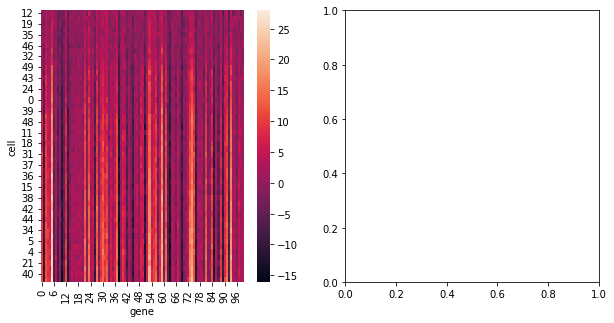

In [132]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

## Types of modular variables

In [144]:
y = la.modular.Multiplicative(
    linear=y_linear,
    linear_subset=y_linear_subset,
    definition=y_linear.value_definition,
    subsettable={genes},
    label = "multi"
)

[[parent.symbol]]_{\mathregular{linear}}
[[parent.symbol]]_{\mathregular{linear\_subset}}


In [145]:
y.plot()

In [146]:
y.prior_pd()

gene,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,,,,,,,,,,,,,,,,,,,,,
0,0.0,5.629153,-8.233907,0.0,0.0,0.0,-0.0,0.0,-0.0,-7.442568,...,1.108850,3.228493,-3.474717,3.834054,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.171467,-6.101713,0.0,0.0,0.0,-0.0,0.0,-0.0,-5.515294,...,0.954543,2.779219,-2.991178,3.300511,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15.996092,-23.397892,0.0,0.0,0.0,-0.0,0.0,-0.0,-21.149185,...,1.869210,5.442336,-5.857399,6.463141,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.030265,-0.044270,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.040015,...,0.081306,0.236729,-0.254783,0.281132,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,31.552696,-46.152935,0.0,0.0,0.0,-0.0,0.0,-0.0,-41.717304,...,2.625242,7.643576,-8.226519,9.077264,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,29.505810,-43.158905,0.0,0.0,0.0,-0.0,0.0,-0.0,-39.011021,...,2.538662,7.391492,-7.955210,8.777897,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,23.662596,-34.611889,0.0,0.0,0.0,-0.0,0.0,-0.0,-31.285437,...,2.273434,6.619262,-7.124085,7.860821,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,16.741163,-24.487728,0.0,0.0,0.0,-0.0,0.0,-0.0,-22.134281,...,1.912247,5.567640,-5.992260,6.611949,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,3.766764,-5.509744,0.0,0.0,0.0,-0.0,0.0,-0.0,-4.980217,...,0.907059,2.640965,-2.842380,3.136324,0.0,0.0,0.0,0.0,0.0,0.0
